# Importando Bibliotecas

In [34]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import warnings
import os

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

import mnist_loader

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Carregando o MNIST dataset

In [3]:
# Loading MNIST dataset
training_data, validation_data, test_data = mnist_loader.load_data()

X_train, Y_train = np.concatenate((training_data[0], validation_data[0])), np.concatenate((training_data[1], validation_data[1]))
X_test, Y_test = test_data[0], test_data[1]

# Definindo os parâmetros da MLP

Os parâmetros testados em busca do melhor desempenho estão descritos abaixo:
<br>
- Número de camadas: Definido aleatoriamente para cada experimento, de forma que cada MLP testado terá 1 ou mais camadas ocultas, com cada camada sendo adicionada caso o número aleatório retornado pelo random.uniform seja maior do que 0.6
- Número de neurônios: Também definido aleatoriamente para cada experimento e camada, sendo um número entre 2 e 100
- Taxa de aprendizagem: Número definido de forma aleatória entre 0.001 e 0.1, tendo no máximo 4 dígitos
- Função de ativação: Escolhido aleatoriamente, podendo ser 'identity', 'logistic', 'tanh' ou 'relu'
- Algoritmo de aprendizagem: Também escolhido aleatoriamente, podendo ser 'adam', 'sgd' ou 'lbfgs'

In [10]:
# Definir a quantidade de camadas escondidas
def random_hidden_layers():
    hidden_layer = [random.randint(2, 100)]
    while random.uniform(0.0, 1.0) > 0.4:
        hidden_layer.append(random.randint(2, 100))
    return hidden_layer

def random_params_mlp(verbose=False, num_epochs=100, tol=0.0001):
    return MLPClassifier(
        activation=random.choice(['identity', 'logistic', 'tanh', 'relu']),
        batch_size='auto',
        early_stopping=True,
        hidden_layer_sizes=random_hidden_layers(),
        learning_rate_init=round(random.uniform(0.0001, 0.1), 4),
        max_iter=num_epochs,
        n_iter_no_change=3,
        solver=random.choice(['adam', 'sgd', 'lbfgs']),
        tol=tol,
        verbose=verbose,
        warm_start=True
    )

# Fazendo um "GridSearch" sobre a camada escondida

Primeiro vamos definir a estrutura do dataframe para armazenar os resultados obtidos durante o gridsearch

In [8]:
if (os.path.exists('model_metrics.csv')):
    model_df = pd.read_csv('model_metrics.csv')
else:
    model_data = {
        'solver': [],
        'activation_function': [],
        'hidden_layers': [],
        'learning_rate': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'fit_time': [],
        'total_epochs': [],
    }
    model_df = pd.DataFrame(model_data)

Foram realizados 25 experimentos, cada um com parâmetros diferentes e escolhidos aleatoriamente usando a biblioteca random, que é nativa do python, com os 3 modelos com maior acurácia total sendo salvos e exibidos ao fim todos os experimentos.

In [11]:
trained_models = []

print("Activation | Solver | LR | Hidden Layers | Total Time | Total Epochs -> Accuracy")
for _ in range(10):
    mlp = random_params_mlp(num_epochs=250)

    start = time.time()
    mlp.fit(X_train, Y_train)
    end = time.time()
    total_time = round(end - start, 1)

    mlp_predictions = mlp.predict(X_test)
    accuracy = accuracy_score(Y_test, mlp_predictions)
    precision = precision_score(Y_test, mlp_predictions, average='macro')
    recall = recall_score(Y_test, mlp_predictions, average='macro')
    f1 = f1_score(Y_test, mlp_predictions, average='macro')
    print(f"{mlp.get_params()['activation']} | {mlp.get_params()['solver']} | {mlp.get_params()['learning_rate_init']} \
| {mlp.get_params()['hidden_layer_sizes']} | {total_time}s | {mlp.n_iter_} -> {accuracy}")

    trained_models.append((mlp, accuracy))
    trained_models = sorted(trained_models, key=lambda tup: tup[1], reverse=True)[:3]

    # Adicionando o modelo ao dataframe de modelos
    model_df.loc[len(model_df)] = {
        'solver': mlp.get_params()['solver'],
        'activation_function': mlp.get_params()['activation'],
        'hidden_layers': str(mlp.get_params()['hidden_layer_sizes']),
        'learning_rate': mlp.get_params()['learning_rate_init'],
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'fit_time': total_time,
        'total_epochs': mlp.n_iter_,
    }

    model_df.to_csv('model_metrics.csv', index=False)

print("\nTop 3 Models:")
for model, acc in trained_models:
    print(f"Accuracy: {acc}, Params: {model.get_params()['hidden_layer_sizes']}")

Activation | Solver | LR | Hidden Layers | Total Time | Total Epochs -> Accuracy
relu | sgd | 0.0626 | [55] | 21.8s | 21 -> 0.9737
logistic | lbfgs | 0.0242 | [56, 26] | 167.4s | 305 -> 0.9602
logistic | adam | 0.0569 | [54, 80] | 14.6s | 11 -> 0.9387
relu | adam | 0.0415 | [42, 99, 77, 85, 2, 89] | 8.9s | 5 -> 0.1135
tanh | lbfgs | 0.0509 | [33, 65] | 92.4s | 188 -> 0.9623
tanh | sgd | 0.0347 | [87] | 12.1s | 23 -> 0.9761
logistic | lbfgs | 0.0133 | [94, 100, 70] | 236.9s | 276 -> 0.9672
tanh | adam | 0.0334 | [19, 96] | 7.7s | 9 -> 0.9263
logistic | sgd | 0.0881 | [70, 9] | 26.9s | 31 -> 0.9751
tanh | sgd | 0.0726 | [47, 46, 78, 71, 98, 43, 90] | 15.7s | 10 -> 0.9684
identity | sgd | 0.0239 | [71, 81] | 9.5s | 16 -> 0.9226
relu | adam | 0.0203 | [23, 33, 43, 6] | 15.4s | 24 -> 0.9171
identity | sgd | 0.0623 | [39, 64, 52] | 2.9s | 7 -> 0.9174
tanh | adam | 0.0788 | [22] | 5.7s | 18 -> 0.9115
logistic | lbfgs | 0.0618 | [58, 43, 34, 60, 38, 78] | 5.6s | 5 -> 0.1135
identity | adam | 0

In [ ]:
model_df

In [ ]:
model_df.to_csv('model_metrics.csv', index=False)

Acima temos os parâmetros para cada um dos 25 Multilayer Perceptrons testados, junto com sua acurácia total e o tempo que levou para treinar cada um deles. <br>
Nota-se que a maioria dos modelos apresentam uma acurácia parecida, com excessão de alguns modelos que possuem 4 camadas ocultas, com o restante dos modelos apresentando uma acurácia total maior do que 0.89.

# Análise da Performance Sobre o Conjunto de Teste

Feita a previsão do modelo com os dados do conjunto de teste, foi calculado a acurácia, precisão e recall total usando ...

In [ ]:
best_model = trained_models[0][0]

In [ ]:
mlp_predictions = best_model.predict(X_test)

## Calculando Acurácia, Precisão e Recall

In [ ]:
accuracy = accuracy_score(Y_test, mlp_predictions)
precision = precision_score(Y_test, mlp_predictions, average='macro')
recall = recall_score(Y_test, mlp_predictions, average='macro')
f1 = f1_score(Y_test, mlp_predictions, average='macro')

In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
#Pegando o report de cada classe 
report = classification_report(Y_test, mlp_predictions, target_names=['0','1','2','3','4','5','6','7','8','9'], output_dict = True)
conf_matrix = confusion_matrix(Y_test, mlp_predictions )
# Calcular a acurácia para cada classe
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i in range(10):
  report[str(i)]['accuracy'] = accuracy_per_class[i]

#Printando a tabela
df = pd.DataFrame(report)
df_inverted = df.transpose()
df = df.drop(columns=['accuracy', 'macro avg', 'weighted avg'])
df

## Plotando a Matrix de Confusão

Também foi exibido a matrix de confusão abaixo de forma a termos uma ideia da performance do melhor modelo para cada uma das suas 10 classes.

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, mlp_predictions)
plt.figure(figsize=(8, 7))

# Heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(10), yticklabels=range(10))

# Labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(11):
    plt.hlines(i, xmin=0, xmax=10, colors='black', linestyles='solid', linewidth=1)
    plt.vlines(i, ymin=0, ymax=10, colors='black', linestyles='solid', linewidth=1)

plt.show()

Observa-se que o modelo tem uma performance boa em todas as classes, acertando a maioria dos casos de teste, errando principalmente os dígitos 8 e 9, onde mais de 30 instâncias foram classificadas incorretamente, porém com 943 e 974, respectivamente, sendo classificadas corretamente.

## Média e Desvio Padrão das Métricas

Por último, iremos calcular a média e desvio padrão dos 3 melhores conjuntos de parâmetros para ter um melhor entendimento do quão bom é a performance dos modelos treinados com esses parâmetros.

In [ ]:
data = {
    'Params': [],
    'Mean Accuracy': [],
    'Std Accuracy': [],
    'Mean Precision': [],
    'Std Precision': [],
    'Mean Recall': [],
    'Std Recall': [],
    'Mean Time': [],
    'Std Time': [],
}

In [ ]:
# Criando 10 modelos para as 3 melhores combinações de parâmetros
for i, model in enumerate(trained_models):
    model = model[0]
    accuracy = []
    precision = []
    recall = []
    fit_time = []
    for _ in range(10):
        start = time.time()
        model.fit(X_train, Y_train)
        end = time.time()
        fit_time.append(round(end - start, 1))

        model_predictions = model.predict(X_test)
        accuracy.append(accuracy_score(Y_test, model_predictions))
        precision.append(precision_score(Y_test, model_predictions, average='weighted'))
        recall.append(recall_score(Y_test, model_predictions, average='weighted'))

    data['Params'].append(f"C{i}")
    data['Mean Accuracy'].append(np.mean(accuracy))
    data['Std Accuracy'].append(np.std(accuracy))
    data['Mean Precision'].append(np.mean(precision))
    data['Std Precision'].append(np.std(precision))
    data['Mean Recall'].append(np.mean(recall))
    data['Std Recall'].append(np.std(recall))
    data['Mean Time'].append(np.mean(fit_time))
    data['Std Time'].append(np.std(fit_time))
df = pd.DataFrame(data)

In [ ]:
df

# Salvando o melhor modelo treinado

Nessa secção está o código para salvar o modelo de melhor performance usando o pickle, outra biblioteca nativa do python, para salvar esse modelo em um arquivo .pkl que pode ser aberto posteriormente com o pickle.load(open(caminho_arquivo_pkl, 'rb')).

In [ ]:
filename = 'test_model.plk'

In [ ]:
# Salvando o modelo em um arquivo
with open(filename, 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# # Carregando um modelo salvo
# with open(filename, 'rb') as f:
#     best_model = pickle.load(f)

In [15]:
data = pd.read_csv('model_metrics_100_0001.csv')
data2 = pd.read_csv('model_metrics_500_0.01.csv')
data3 = pd.read_csv('model_metrics_500_00001.csv')

In [18]:
df = pd.concat([data, data2, data3], ignore_index=True)

In [19]:
df

,solver,activation_function,hidden_layers,learning_rate,accuracy,precision,recall,f1_score,fit_time,total_epochs
0,sgd,logistic,"[64, 19, 4, 79, 99, 76, 19, 69]",0.0711,0.1135,0.011350,0.100000,0.020386,9.9,7
1,sgd,relu,"[77, 33, 70, 65]",0.0021,0.9677,0.967661,0.967316,0.967425,27.8,38
2,lbfgs,relu,"[78, 17, 68]",0.0198,0.9619,0.961637,0.961626,0.961597,54.1,100
3,lbfgs,tanh,[55],0.0802,0.9623,0.962036,0.961995,0.961984,40.2,100
4,adam,logistic,[53],0.0391,0.9606,0.960712,0.960235,0.960381,7.1,13
...,...,...,...,...,...,...,...,...,...,...
95,adam,tanh,"[64, 64, 69]",0.0506,0.8797,0.883178,0.877532,0.878397,6.1,7
96,lbfgs,logistic,"[96, 39]",0.0109,0.9719,0.971617,0.971581,0.971586,120.9,206
97,adam,relu,[33],0.0845,0.9065,0.905364,0.905689,0.904965,3.5,8
98,adam,identity,[67],0.0793,0.8890,0.890120,0.887548,0.886344,2.5,5


In [25]:
result = df.sort_values(['accuracy'], ascending=False)
result

,solver,activation_function,hidden_layers,learning_rate,accuracy,precision,recall,f1_score,fit_time,total_epochs
17,sgd,tanh,"[88, 82, 48]",0.0604,0.9795,0.979310,0.979242,0.979241,13.2,17
80,sgd,tanh,[87],0.0347,0.9761,0.976080,0.975886,0.975963,12.1,23
83,sgd,logistic,"[70, 9]",0.0881,0.9751,0.975010,0.974725,0.974829,26.9,31
93,sgd,tanh,[87],0.0149,0.9749,0.974806,0.974610,0.974676,22.3,44
91,lbfgs,tanh,"[97, 63, 67, 73]",0.0700,0.9738,0.973665,0.973507,0.973563,113.1,132
...,...,...,...,...,...,...,...,...,...,...
48,lbfgs,logistic,"[81, 11, 52]",0.0073,0.1135,0.011350,0.100000,0.020386,1.5,1
55,sgd,logistic,"[3, 43, 92, 56, 82]",0.0166,0.1135,0.011350,0.100000,0.020386,4.3,6
61,adam,relu,"[86, 65, 16]",0.0780,0.1135,0.011350,0.100000,0.020386,4.1,5
58,sgd,logistic,"[60, 54, 89, 71, 86]",0.0618,0.1032,0.010320,0.100000,0.018709,5.6,5


### Acurácia x Total de Épocas

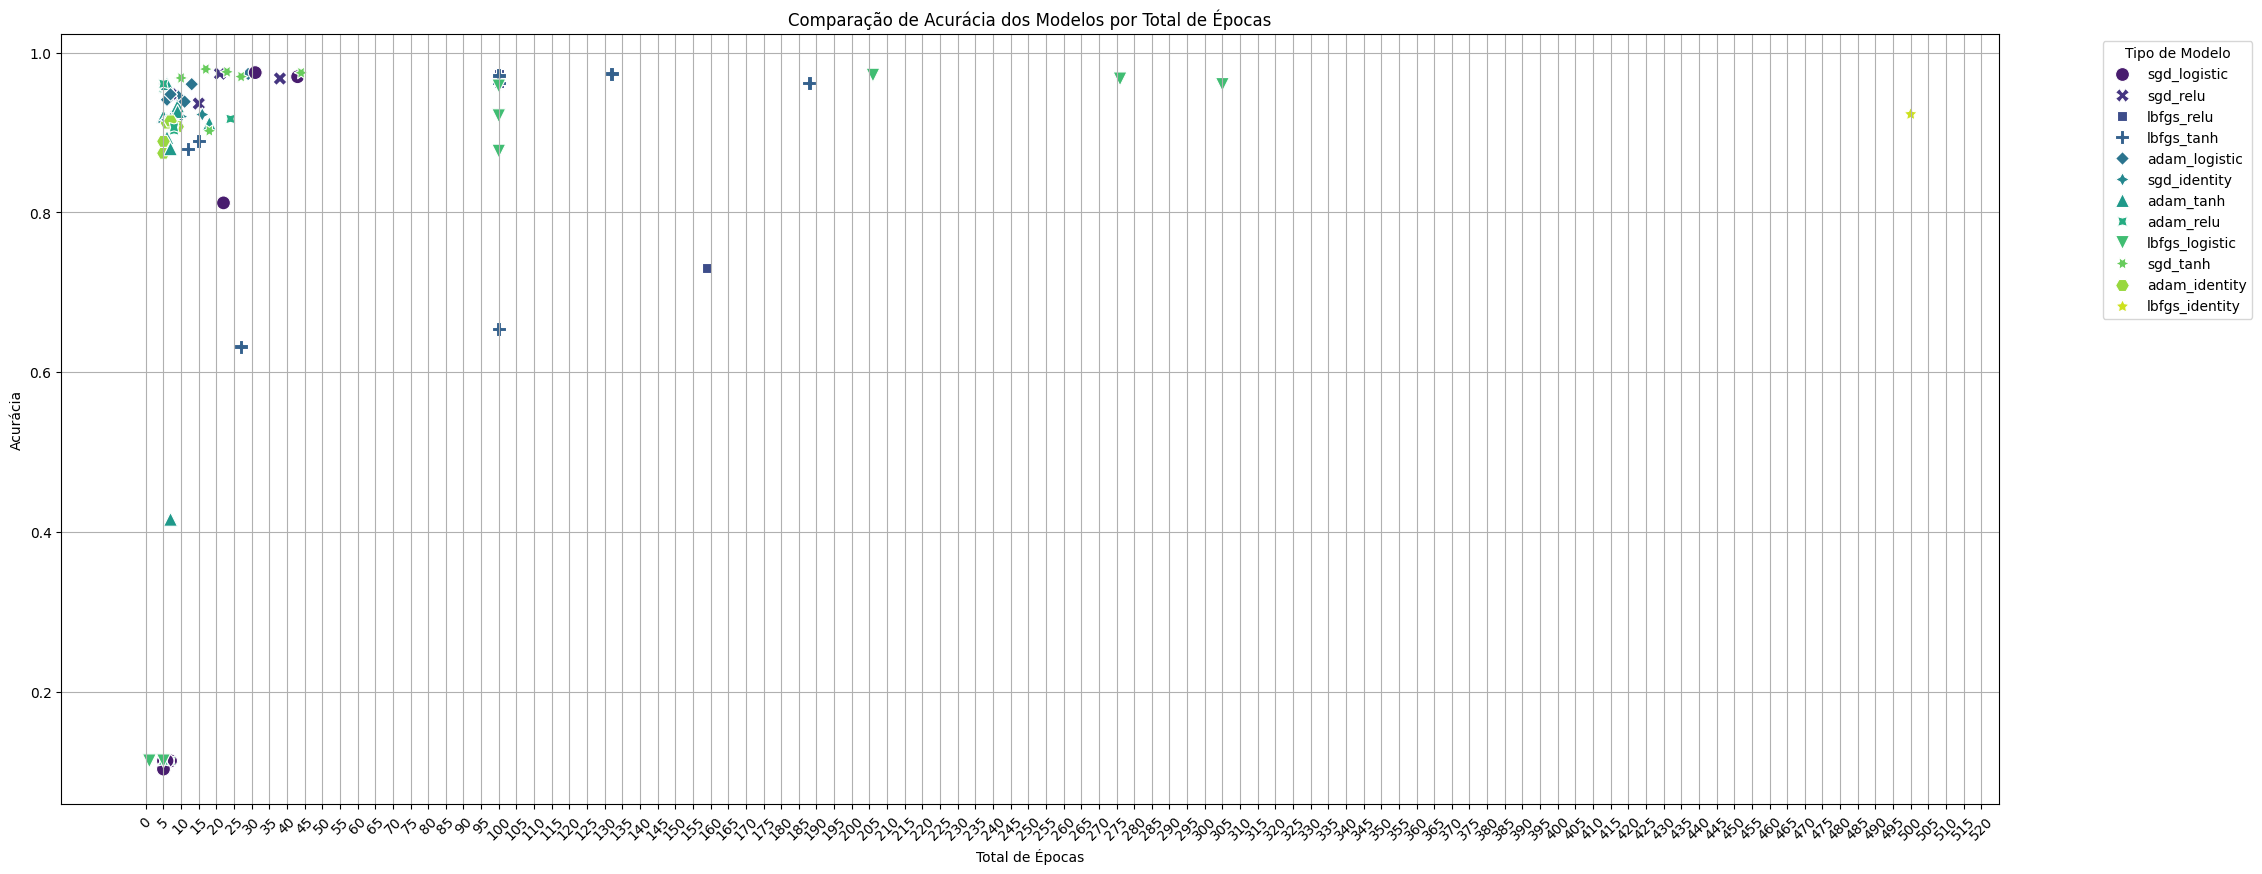

In [54]:
plt.figure(figsize=(25, 10))
df['model_type'] = df['solver'] + '_' + df['activation_function']

sns.scatterplot(data=df, x='total_epochs', y='accuracy', hue='model_type', style='model_type', markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Épocas')
plt.xlabel('Total de Épocas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 5))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

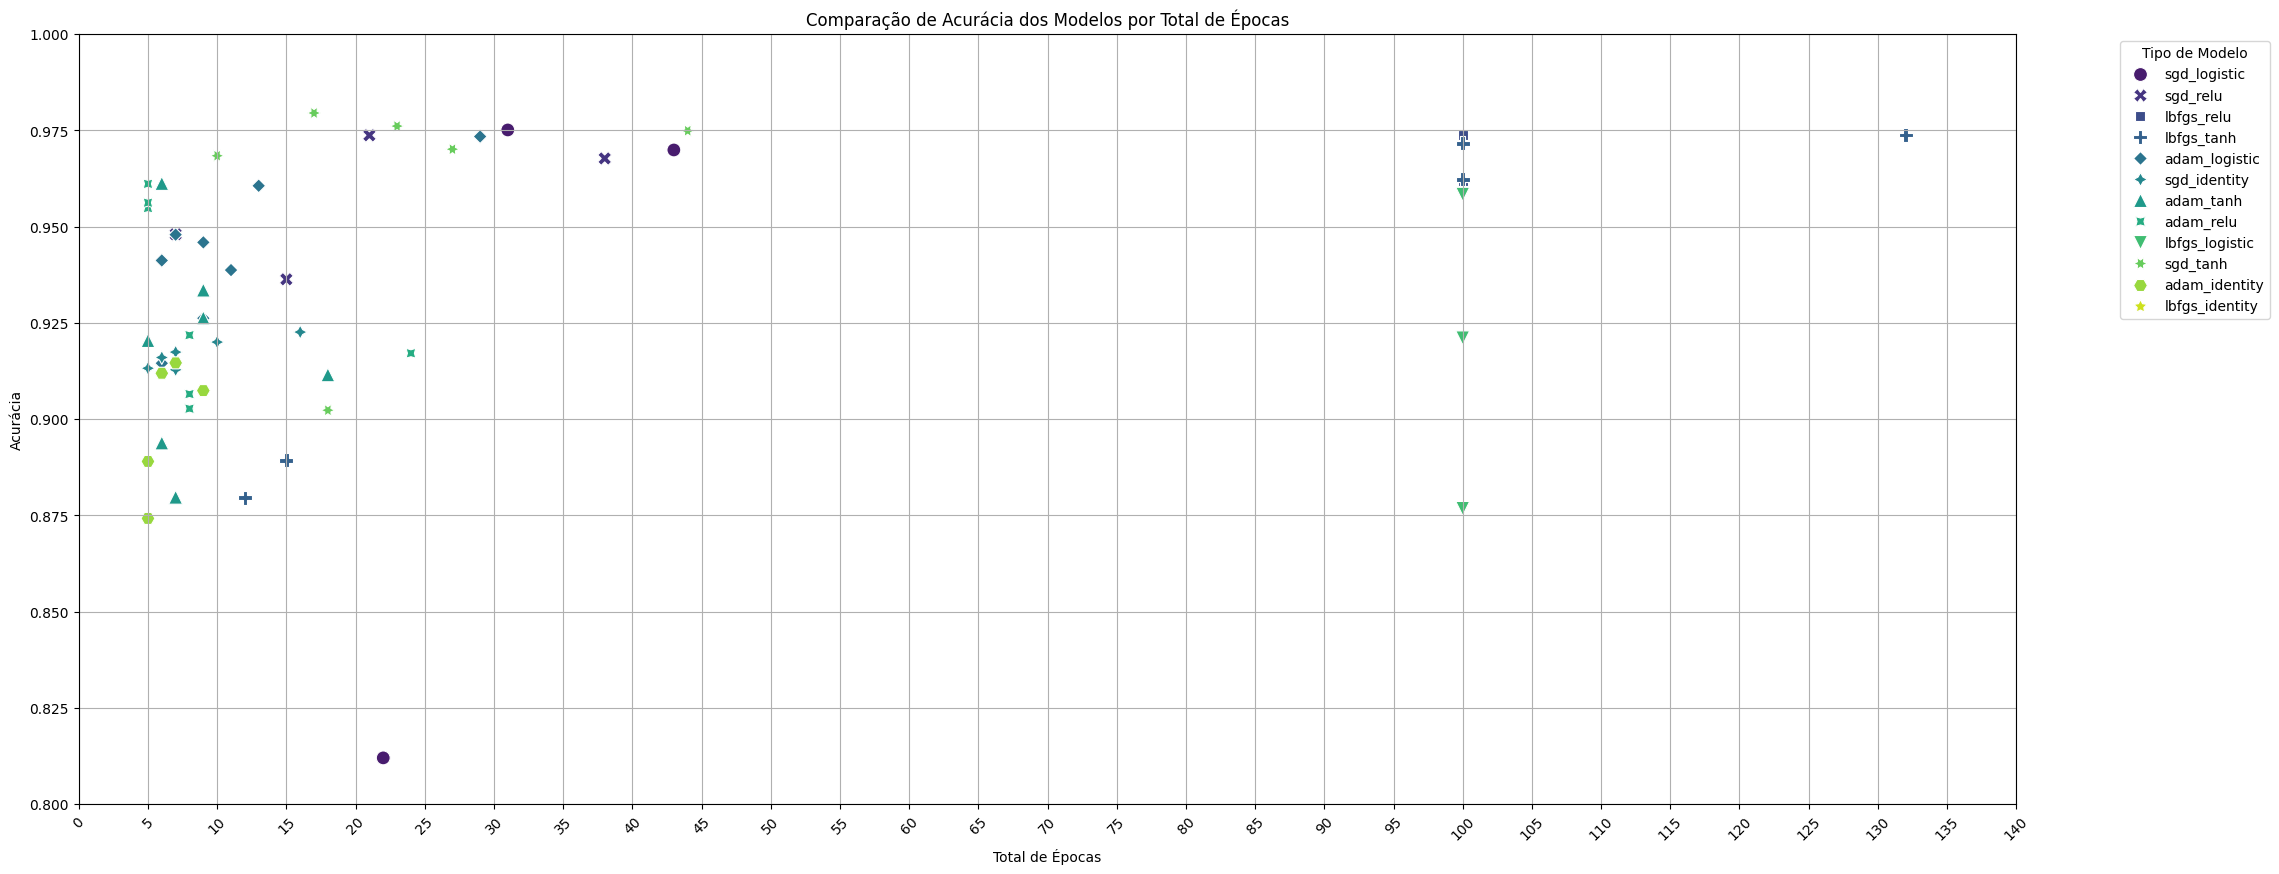

In [61]:

plt.figure(figsize=(25, 10))
df['model_type'] = df['solver'] + '_' + df['activation_function']

sns.scatterplot(data=df, x='total_epochs', y='accuracy', hue='model_type', style='model_type', markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Épocas')
plt.xlabel('Total de Épocas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 5))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 


plt.xlim(0, 140)  
plt.ylim(0.8, 1.0) 

plt.show()

### Acurácia x Quantidade Total de Neurônios

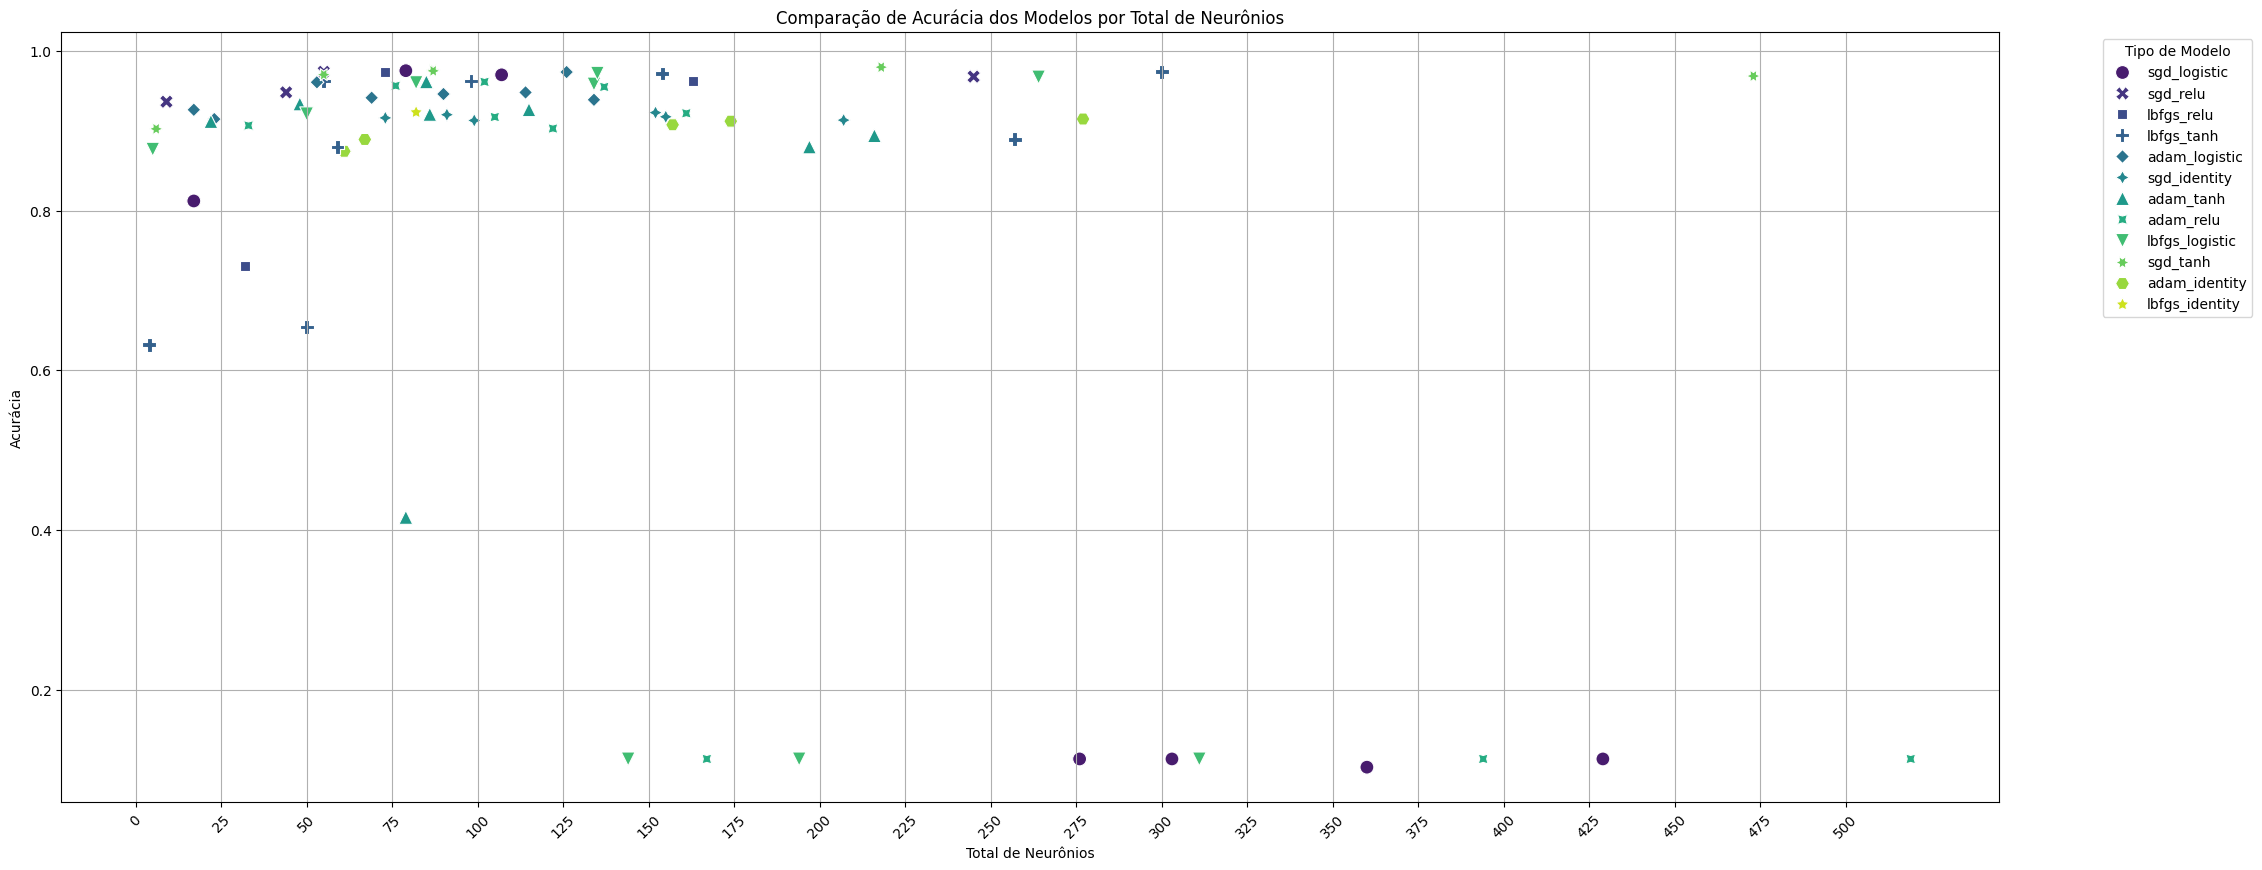

In [64]:
df['total_neurons'] = df['hidden_layers'].apply(lambda x: sum(eval(x)))

plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='total_neurons', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)  # Ajustando o tamanho dos pontos para melhor visualização

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Neurônios')
plt.xlabel('Total de Neurônios')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 25))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()


### Acurácia x Número de Camadas

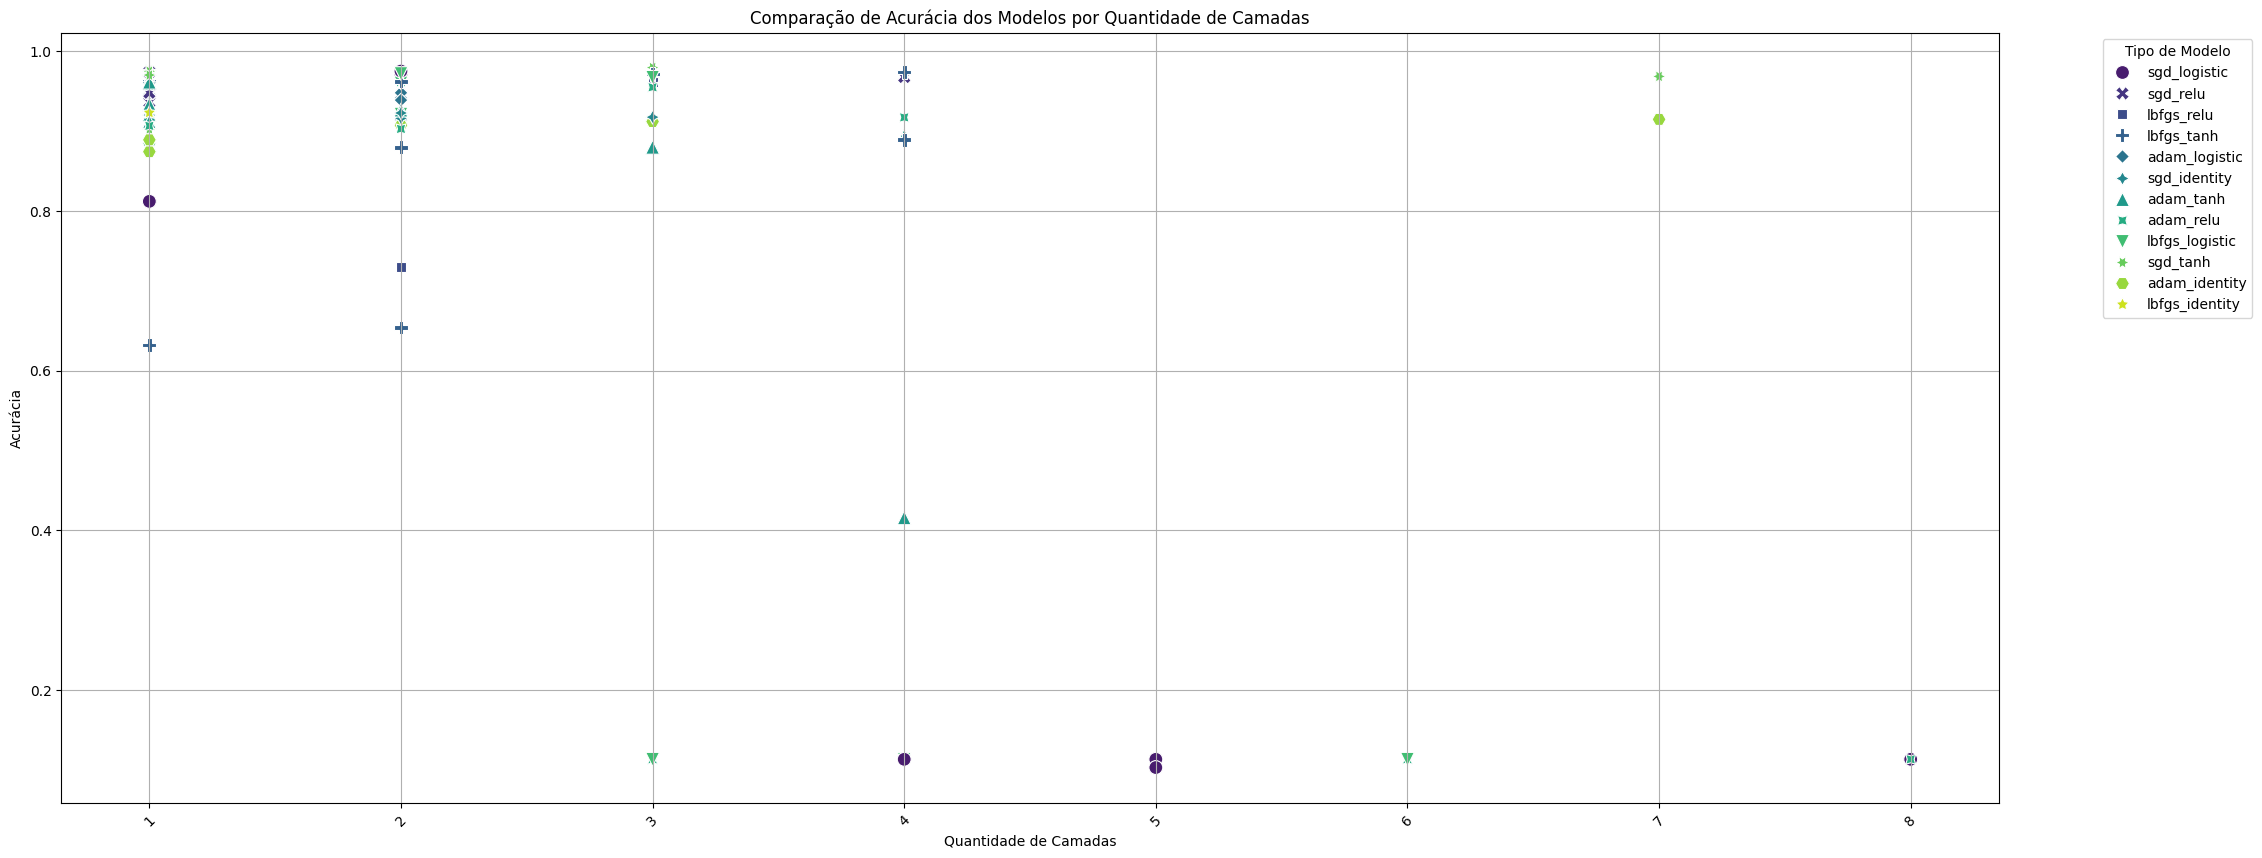

In [65]:
df['num_layers'] = df['hidden_layers'].apply(lambda x: len(eval(x)))

plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='num_layers', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)  # Ajustando o tamanho dos pontos para melhor visualização

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Quantidade de Camadas')
plt.xlabel('Quantidade de Camadas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()


### Acurácia x Learning Rate

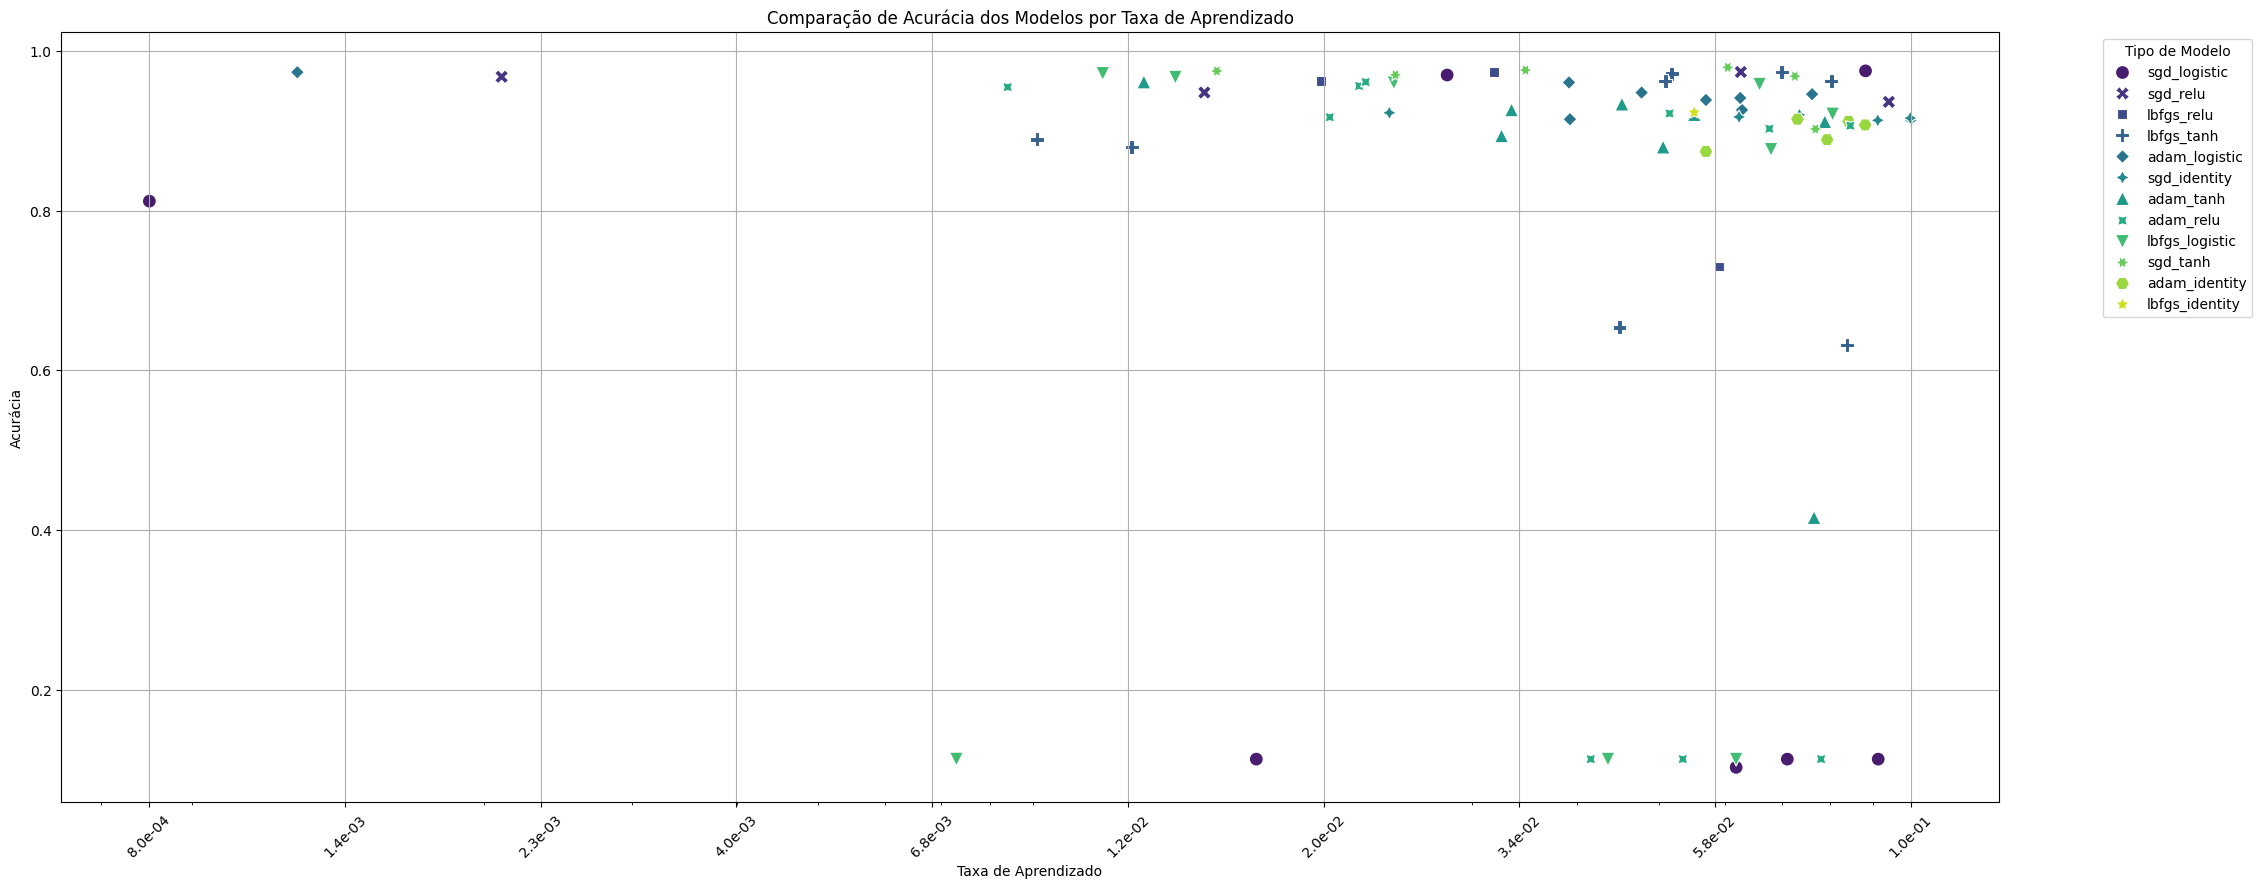

In [67]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=df, x='learning_rate', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Taxa de Aprendizado')
plt.xlabel('Taxa de Aprendizado')
plt.ylabel('Acurácia')
plt.xscale('log')  
# Ajustando os ticks do eixo x para maior granularidade
min_lr = df['learning_rate'].min()
max_lr = df['learning_rate'].max()
ticks = np.logspace(np.log10(min_lr), np.log10(max_lr), num=10)  
plt.xticks(ticks, labels=[f"{x:.1e}" for x in ticks])  
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()
